Here we are loading the long format of the raw data 

In [781]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

raw_data = pd.read_csv("/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/raw/long_df.csv")
raw_data["date"] = pd.to_datetime(raw_data['date'], errors='coerce')
raw_data.head()

,Series,date,value
0,N1877,1982-01-01,3650.16
1,N1877,1982-02-01,3072.22
2,N1877,1982-03-01,3156.06
3,N1877,1982-04-01,2893.04
4,N1877,1982-05-01,2983.52


Here we can observe that multiple ids can have different values at the same time step

In [782]:
raw_data[raw_data['date'] ==  pd.Timestamp('1982-01-01')]

,Series,date,value
0,N1877,1982-01-01,3650.16
141,N1878,1982-01-01,5379.20
342,N1879,1982-01-01,5424.50
620,N1881,1982-01-01,2525.00
705,N1882,1982-01-01,4920.00
...,...,...,...
42431,N2179,1982-01-01,2755.00
42575,N2180,1982-01-01,2208.00
44856,N2197,1982-01-01,2416.00
46204,N2207,1982-01-01,800.00


Here we are printing the sequence(all the time steps) of a speicif id

In [783]:
raw_data[raw_data["Series"] == "N1877"] 

,Series,date,value
0,N1877,1982-01-01,3650.16
1,N1877,1982-02-01,3072.22
2,N1877,1982-03-01,3156.06
3,N1877,1982-04-01,2893.04
4,N1877,1982-05-01,2983.52
...,...,...,...
136,N1877,1993-05-01,3861.44
137,N1877,1993-06-01,4460.38
138,N1877,1993-07-01,5173.90
139,N1877,1993-08-01,5189.24


Here we are splitting the raw data into train, val, test

In [784]:
raw_data.shape

(46626, 3)

In [826]:
import pandas as pd

def temporal_split_per_series(df: pd.DataFrame,
                              id_col="Series", time_col="date",
                              ):
    """
    For each Series:
      - 15% data -> test
      - 15% data -> val
      - the rest         -> train
    Works with unequal series lengths and keeps time order.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

    parts = {"train": [], "val": [], "test": []}

    for sid, g in df.groupby(id_col, sort=False):
        g = g.sort_values(time_col)
        number_of_samples = g.shape[0]
        split_range = int(float(number_of_samples) * 0.15)

        g_test = g.iloc[-split_range:]
        g_rem  = g.iloc[:-split_range]

        
        g_val  = g_rem.iloc[-split_range:]
        g_train = g_rem.iloc[:-split_range]

        parts["train"].append(g_train)
        parts["val"].append(g_val)
        parts["test"].append(g_test)

    train = pd.concat(parts["train"], ignore_index=True) 
    val   = pd.concat(parts["val"],   ignore_index=True) 
    test  = pd.concat(parts["test"],  ignore_index=True)

    return train, val, test

train_df, val_df, test_df = temporal_split_per_series(raw_data)
print(len(train_df), len(val_df), len(test_df))


33012 6807 6807


Here we are saving the train, val, test raw data into the data/raw directory

In [827]:
import os
from pathlib import Path

main_directory = Path.cwd().resolve().parent
print(main_directory)

out_dir = main_directory / "data/raw"                 
os.makedirs(out_dir, exist_ok=True) 
     
csv_path_1 = os.path.join(out_dir, "train_raw_df.csv")
train_df.to_csv(csv_path_1, index=False)

csv_path_2 = os.path.join(out_dir, "val_raw_df.csv")
val_df.to_csv(csv_path_2, index=False)

csv_path_2 = os.path.join(out_dir, "test_raw_df.csv")
test_df.to_csv(csv_path_2, index=False)

print("Saved:", csv_path_1, csv_path_2)

/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting
Saved: /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/raw/train_raw_df.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/raw/test_raw_df.csv


Here we are plotting the N1877 sequence, after splitting 

In [828]:
train_df[train_df["Series"] == "N1878"] 

,Series,date,value
99,N1878,1982-01-01,5379.2
100,N1878,1982-02-01,5338.0
101,N1878,1982-03-01,5977.0
102,N1878,1982-04-01,5585.6
103,N1878,1982-05-01,5594.2
...,...,...,...
193,N1878,1989-11-01,4237.2
194,N1878,1989-12-01,4364.6
195,N1878,1990-01-01,4682.4
196,N1878,1990-02-01,4830.2


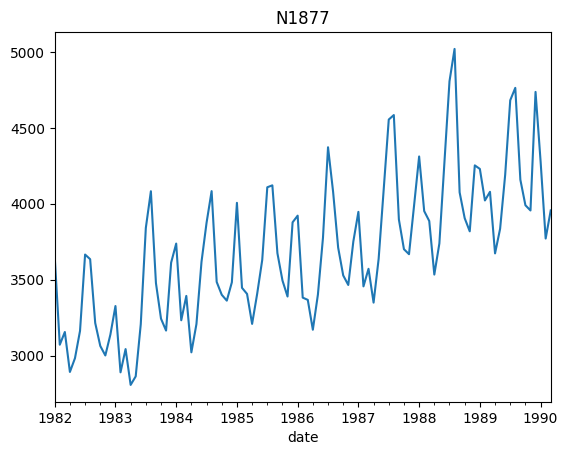

In [788]:
train_df.query("Series == 'N1877'").sort_values('date').set_index('date')['value'].plot(title='N1877'); 

Cehcking if the raw train_df with ID N1877 is stationary, but as we can observe the p-value . 0.05 which means is not stationary 

In [789]:
from statsmodels.tsa.stattools import adfuller

# one series of values (Pandas Series), e.g. for a single ID
res = train_df.query("Series == 'N1877'")["value"].dropna()

adf_stat, pval, lags, nobs, crit, icbest = adfuller(res, autolag="AIC")
print(f"ADF stat: {adf_stat:.3f}  |  p-value: {pval:.4f}  |  used lags: {lags}  |  nobs: {nobs}")
print("Critical values:", crit)

ADF stat: -0.937  |  p-value: 0.7755  |  used lags: 12  |  nobs: 86
Critical values: {'1%': np.float64(-3.5087828609430614), '5%': np.float64(-2.895783561573195), '10%': np.float64(-2.5850381719848565)}


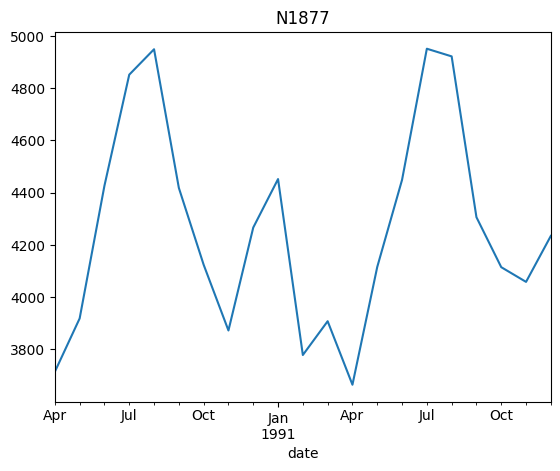

In [790]:
val_df.query("Series == 'N1877'").sort_values('date').set_index('date')['value'].plot(title='N1877'); 

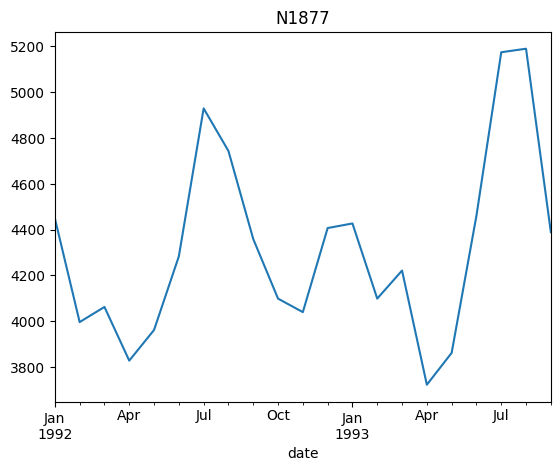

In [791]:
test_df.query("Series == 'N1877'").sort_values('date').set_index('date')['value'].plot(title='N1877'); 

Here we start the decomposition of the training data(leakeage safe) in order to obtain the trend, seasonality and residuals. We are using STL method to decompose it ( y_t = trend_t + seasonal_t + resid_t). But first we apply a log to the training data to make it additive from multiplicative. stl_decompose_panel(...) runs STL decomposition separately for each series (ID) in a panel.

In [792]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL

def stl_decompose_panel(
    train_df: pd.DataFrame,
    id_col: str = "Series",
    time_col: str = "date",
    value_col: str = "value",
    period: int = 12,                  # e.g., 12 for monthly
    transform: str = "none",           # "none" | "log" | "log1p"
    robust: bool = True,
    seasonal: int | None = None,       # STL seasonal window (odd int or None=auto)
    trend: int | None = None,          # STL trend window (odd int or None=auto)
    min_points: int = None,            # minimum length to attempt STL; default 2*period+1
) -> pd.DataFrame:
    """
    Decompose each ID in train_df with STL: y_t = trend_t + seasonal_t + resid_t.
    Returns a DataFrame with columns:
      [id_col, time_col, value_col, 'y_trans', 'trend', 'seasonal', 'resid', 'n_obs'].

    Notes
    -----
    - Runs per ID, on the *training set you pass in* (no leakage).
    - If transform='log' (strictly positive y) or 'log1p' (handles zeros),
      decomposition is done on the transformed scale; outputs are on that same scale.
    - Short series (len < min_points) are skipped.
    """
    # here we take the training data and and sort them based on time and id
    # train_df[["Series", "date", "value"]]
    df = train_df[[id_col, time_col, value_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col, value_col]).sort_values([id_col, time_col])

    if min_points is None:
        min_points = 2 * period + 1

    out_frames = []

    # loops over IDs -> gid=["N1877"] and g is the sub-DataFrame containing all the rows
    for gid, g in df.groupby(id_col, sort=False):
        # y is the array of all the values at each time step per ID
        # g["value"] for N1877
        y = g[value_col].to_numpy(dtype=float)
        n = len(y)
        if n < min_points or period <= 1:
            # not enough data to sensibly decompose
            continue

        # transform the y
        if transform == "log":
            if np.any(y <= 0):
                # cannot log non-positive values; skip this ID
                continue
            y_t = np.log(y)
        elif transform == "log1p":
            y_t = np.log1p(y)   # works with zeros
        else:
            y_t = y.copy()

        # seasonal window should be >= period and odd
        # trend window should be large and odd
        def _odd(x):  
            x = int(x)
            return x if x % 2 == 1 else x + 1

        seas_win = _odd(max(period, 7)) if seasonal is None else seasonal
        trend_win = _odd(max(2 * period + 1, 13)) if trend is None else trend

        try:
            stl = STL(
                y_t,
                period=period,
                seasonal=seas_win,
                trend=trend_win,
                robust=robust
            ).fit()
        except Exception:
            continue
        
        # this contains the initial values = y, the tranformed values = y_t 
        comp = pd.DataFrame({
            id_col: gid,
            time_col: g[time_col].values,
            value_col: y,
            "value_trans": y_t,
            "trend": stl.trend,
            "seasonal": stl.seasonal,
            "resid": stl.resid,
            "n_obs": n,
        })
        out_frames.append(comp)

    if not out_frames:
        # return empty with expected columns
        return pd.DataFrame(columns=[id_col, time_col, value_col, "value_trans", "trend", "seasonal", "resid", "n_obs"])

    return pd.concat(out_frames, ignore_index=True)

decomp_df = stl_decompose_panel(
    train_df,
    id_col="Series",
    time_col="date",
    value_col="value",
    period=12,          # monthly data
    transform="log",  # or "none"/"log" if strictly positive
    robust=True
)


# These are the results for one Id
decomp_df.query("Series == 'N1877'")[["Series","date","value","value_trans","trend","seasonal","resid"]].head()


,Series,date,value,value_trans,trend,seasonal,resid
0,N1877,1982-01-01,3650.16,8.202526,8.072655,0.131866,-0.001995
1,N1877,1982-02-01,3072.22,8.030156,8.072537,-0.036008,-0.006373
2,N1877,1982-03-01,3156.06,8.057080,8.072483,-0.029181,0.013777
3,N1877,1982-04-01,2893.04,7.970063,8.072509,-0.120094,0.017648
4,N1877,1982-05-01,2983.52,8.000859,8.072629,-0.069752,-0.002018


Decomp_df contains all the decomposed item for each id -> value_trans(after applying log), value(without applying log), tend, seasonal, resid 

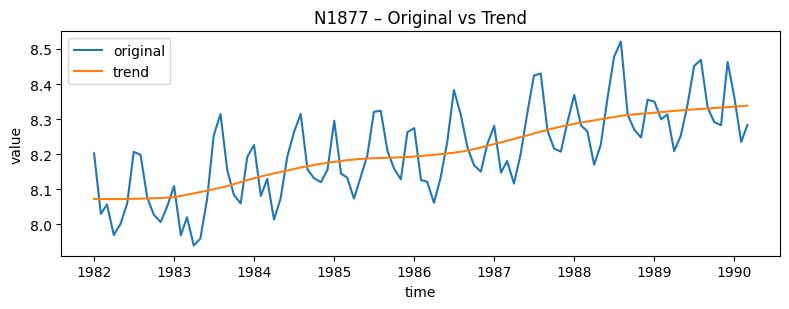

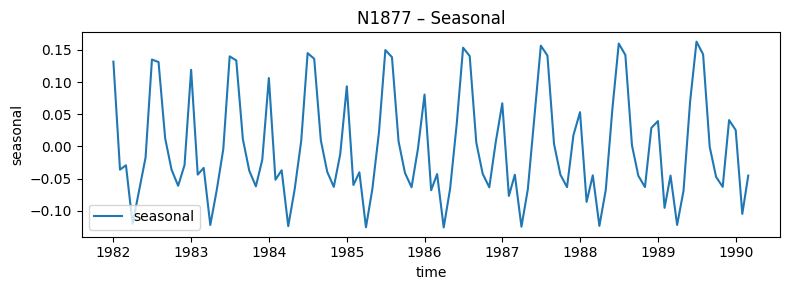

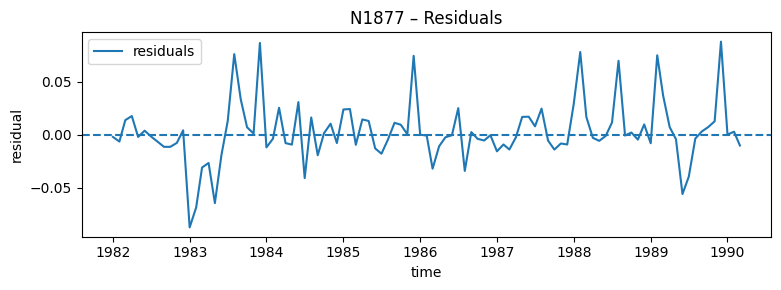

In [793]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stl_for_id(decomp_df: pd.DataFrame, series_id, 
                    id_col="Series", time_col="date", value_col="value"):
    """
    Plot original vs. trend, seasonality, and residuals for one ID.
    Creates three separate figures (no subplots).
    """
    t = (decomp_df.loc[decomp_df[id_col] == series_id, 
                       [time_col, value_col, "value_trans", "trend", "seasonal", "resid"]]
         .sort_values(time_col))
    if t.empty:
        print(f"No rows for {series_id}")
        return

    # 1) Original vs Trend
    plt.figure(figsize=(8, 3.2))
    plt.plot(t[time_col], t["value_trans"], label="original")
    plt.plot(t[time_col], t["trend"], label="trend")
    plt.title(f"{series_id} – Original vs Trend")
    plt.xlabel("time"); plt.ylabel(value_col); plt.legend(); plt.tight_layout()
    plt.show()

    # 2) Seasonal
    plt.figure(figsize=(8, 3.0))
    plt.plot(t[time_col], t["seasonal"], label="seasonal")
    plt.title(f"{series_id} – Seasonal")
    plt.xlabel("time"); plt.ylabel("seasonal"); plt.legend(); plt.tight_layout()
    plt.show()

    # 3) Residuals
    plt.figure(figsize=(8, 3.0))
    plt.plot(t[time_col], t["resid"], label="residuals")
    plt.axhline(0, linestyle="--")
    plt.title(f"{series_id} – Residuals")
    plt.xlabel("time"); plt.ylabel("residual"); plt.legend(); plt.tight_layout()
    plt.show()


plot_stl_for_id(decomp_df, "N1877")



Here we are checking if the residuals of the sequence N1877 are stationary, as we can see they are 

In [794]:
from statsmodels.tsa.stattools import adfuller

# one series of residuals (Pandas Series), e.g. for a single ID
res = decomp_df.query("Series == 'N1877'")["resid"].dropna()

adf_stat, pval, lags, nobs, crit, icbest = adfuller(res, autolag="AIC")
print(f"ADF stat: {adf_stat:.3f}  |  p-value: {pval:.4f}  |  used lags: {lags}  |  nobs: {nobs}")
print("Critical values:", crit)

ADF stat: -7.459  |  p-value: 0.0000  |  used lags: 0  |  nobs: 98
Critical values: {'1%': np.float64(-3.4989097606014496), '5%': np.float64(-2.891516256916761), '10%': np.float64(-2.5827604414827157)}


Here we are creating 3 different dfs that will store the residuals, seasonality and tren for each id

In [795]:
resid_train = decomp_df[["Series", "date", "resid"]]
resid_train.head()

,Series,date,resid
0,N1877,1982-01-01,-0.001995
1,N1877,1982-02-01,-0.006373
2,N1877,1982-03-01,0.013777
3,N1877,1982-04-01,0.017648
4,N1877,1982-05-01,-0.002018


In [796]:
trend_train = decomp_df[["Series", "date", "trend"]]
trend_train.head()

,Series,date,trend
0,N1877,1982-01-01,8.072655
1,N1877,1982-02-01,8.072537
2,N1877,1982-03-01,8.072483
3,N1877,1982-04-01,8.072509
4,N1877,1982-05-01,8.072629


In [797]:
season_train = decomp_df[["Series", "date", "seasonal"]]
season_train.head()

,Series,date,seasonal
0,N1877,1982-01-01,0.131866
1,N1877,1982-02-01,-0.036008
2,N1877,1982-03-01,-0.029181
3,N1877,1982-04-01,-0.120094
4,N1877,1982-05-01,-0.069752


Here we are checking if the training residuals(of each id) are all stationary. If they are not aLready stationary, we apply diff() for the sequence. We keep track of how every sequence was changed throught a log(what sequence was modified and how many diff() were being applied).

In [798]:
from typing import Tuple


def _adf_pvalue(x: np.ndarray, autolag: str = "AIC"):
    """
    Run ADF on a 1D array and return (stat, pval, used_lags, nobs).
    Short-circuits with NaNs if <15 non-NaN observations.
    """
    x = pd.Series(x).dropna().values
    if len(x) < 15:
        return (np.nan, np.nan, np.nan, len(x))
    adf_stat, pval, lags, nobs, *_ = adfuller(x, autolag=autolag)
    return (adf_stat, pval, lags, nobs)


def difference_until_stationary(
    df: pd.DataFrame,
    id_col: str = "Series",
    time_col: str = "date",
    value_col: str = "resid",
    alpha: float = 0.05,
    max_d: int = 1,                      # only regular differencing, default at most once
    autolag: str = "AIC",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Make each per-ID series stationary by applying up to `max_d` regular differences
    (no seasonal differencing). Stops early if ADF p-value < alpha.

    Parameters
    ----------
    df : DataFrame
        Long panel with columns [id_col, time_col, value_col].
    id_col : str
        Series identifier column.
    time_col : str
        Datetime column; parsed and sorted per ID.
    value_col : str
        Target series to difference (e.g., residuals).
    alpha : float
        ADF significance threshold.
    max_d : int
        Max number of regular differences to try (default 1).
    autolag : {"AIC","BIC","t-stat",None}
        Lag selection for ADF.
    only_ids : list[str] or None
        If provided, only these IDs are processed; others pass through unchanged.

    Returns
    -------
    diff_df : DataFrame
        Original rows with new column f"{value_col}_diff"; NaNs from differencing dropped.
    decisions : DataFrame
        Per-ID summary: [id_col, d, final_adf_stat, final_pvalue, used_lags, nobs, verdict]
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

    out_frames, logs = [], []
    target_col = "resid"

    # here again, it is looping through sequences(per Id)
    for sid, g in df.groupby(id_col, sort=False):

        #it sorts the values of a sequence based on the time 
        gg = g.sort_values(time_col).copy()

        # series= gg["resid"]
        series = gg[value_col].astype(float).to_numpy()
        d = 0

        adf_stat, pval, lags, nobs = _adf_pvalue(series, autolag=autolag)

        # here if the p-value is lower than 0.05, then another diff() is being used
        while (pval >= alpha) and (d < max_d):
            series = pd.Series(series).diff().values
            # count the number of diff() per sequence that would lead to p-value < 0.05
            d += 1
            adf_stat, pval, lags, nobs = _adf_pvalue(series, autolag=autolag)

        # here the new sequences are being created and added to the column
        diffed = gg[value_col].astype(float).copy()
        for _ in range(d):
            diffed = diffed.diff()

        gg[target_col] = diffed.values
        gg = gg.dropna(subset=[target_col])
        out_frames.append(gg)

        # here we create a log for each sequence(Id)
        logs.append({
            id_col: sid, "d": d,
            "final_adf_stat": adf_stat, "final_pvalue": pval,
            "used_lags": lags, "nobs": nobs,
            "verdict": ("stationary" if (pval < alpha) else "non_stationary")
        })

    diff_df = (pd.concat(out_frames, ignore_index=True)
               if out_frames else df.assign(**{target_col: np.nan}).dropna(subset=[target_col]))
    decisions = pd.DataFrame(logs)

    # Brief summary
    changed = decisions.query("d > 0")
    ids_reg = decisions.loc[decisions["d"] > 0, id_col].tolist()
    print(f"IDs needing regular differencing: {len(changed)}")
    if ids_reg:
        print(f" • d>0: {len(ids_reg)} ids")
        print(f"   {ids_reg[:20]}{' ...' if len(ids_reg)>20 else ''}")

    tested = decisions["verdict"].isin(["stationary","non_stationary"]).sum()
    passed = decisions["verdict"].eq("stationary").sum()
    rate = passed / tested if tested else np.nan
    print(f"ADF after differencing @ alpha={alpha}: {passed}/{tested} stationary ({rate:.1%}).")

    return diff_df, decisions

diff_train, diff_log = difference_until_stationary(
    resid_train,
    id_col="Series", time_col="date", value_col="resid",
    alpha=0.05, max_d=2 
)


IDs needing regular differencing: 17
 • d>0: 17 ids
   ['N1888', 'N1933', 'N1983', 'N2032', 'N2050', 'N2052', 'N2077', 'N2086', 'N2091', 'N2094', 'N2103', 'N2113', 'N2158', 'N2159', 'N2161', 'N2169', 'N2174']
ADF after differencing @ alpha=0.05: 333/333 stationary (100.0%).


Here we are plotting the resid_train data after applying diff

In [799]:
diff_train.head()

,Series,date,resid
0,N1877,1982-01-01,-0.001995
1,N1877,1982-02-01,-0.006373
2,N1877,1982-03-01,0.013777
3,N1877,1982-04-01,0.017648
4,N1877,1982-05-01,-0.002018


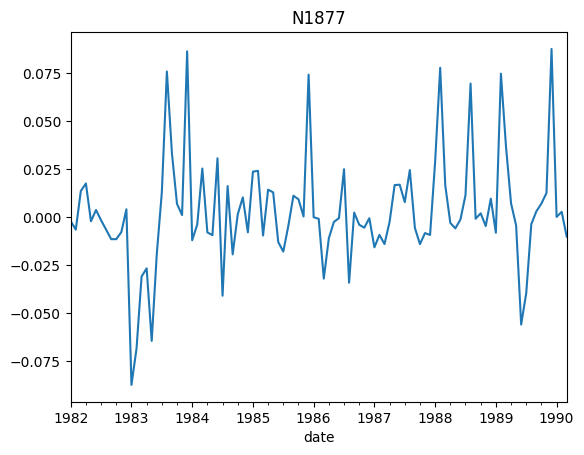

In [800]:
diff_train.query("Series == 'N1877'").sort_values('date').set_index('date')['resid'].plot(title='N1877'); 

Here we are normalizing the resid_train to the Z distribution (X - mean / std). We need to find a global mean and std (over all Ids)

In [801]:
from typing import Dict

def fit_global_zscore(train_df: pd.DataFrame, value_col: str = "resid") -> Dict[str, float]:
    """
    Fit ONE global z-score scaler on TRAIN residuals.
    Returns {"mu": ..., "sigma": ...}.
    """
    x = train_df[value_col].dropna().to_numpy()
    mu = float(np.mean(x))
    sigma = float(np.std(x, ddof=1))
    if sigma == 0:
        sigma = 1e-8
    return {"mu": mu, "sigma": sigma}

def transform_global_zscore(df: pd.DataFrame, scaler: Dict[str, float],
                            value_col: str = "resid", out_col: str = "resid") -> pd.DataFrame:
    """Apply the fitted global z-score scaler to any dataframe."""
    out = df.copy()
    out[out_col] = (out[value_col] - scaler["mu"]) / scaler["sigma"]
    return out

def inverse_global_zscore(z, scaler: Dict[str, float]) -> pd.Series:
    """Invert z = (x-mu)/sigma back to original residual scale."""
    z = pd.Series(z)
    return z * scaler["sigma"] + scaler["mu"]


Here is the mean and std across all of the sequences(Ids)

The mean is -0.0014586630979272239 with a variance of 0.13211151290270995


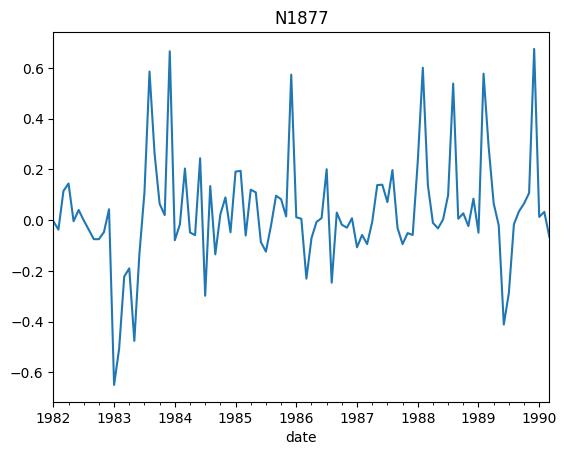

In [802]:
scaler = fit_global_zscore(diff_train, value_col="resid")
print(f"The mean is {scaler["mu"]} with a variance of {scaler["sigma"]}")

train_scaled = transform_global_zscore(diff_train, scaler, value_col="resid", out_col="resid")
train_scaled.query("Series == 'N1877'").sort_values('date').set_index('date')['resid'].plot(title='N1877'); 


Forecast the trend component for each series (ID) into the validation (and optionally test) horizons, using Holt’s linear trend ( double exponential smoothing). It fits only on TRAIN trend from the STL output → no leakage.

In [803]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holt_trend_forecast_to_val(
    trend_train: pd.DataFrame,         # STL on TRAIN ONLY
    val_df: pd.DataFrame,            # validation rows (id/time)
    test_df: pd.DataFrame | None = None,   # OPTIONAL: test rows (id/time)
    id_col: str = "Series",
    time_col: str = "date",
    trend_col: str = "trend",
    damped: bool = True,
    optimized: bool = True,
):
    """
    For each ID:
      1) Fit Holt's linear model on TRAIN trend (from `trend_train`).
      2) Forecast exactly len(VAL) steps (and, if `test_df` is given, len(VAL)+len(TEST)).
      3) Return dataframes aligned to the provided VAL/TEST dates.

    Returns:
      val_fcst : DataFrame [id_col, time_col, 'trend_fcst', 'n_train', 'n_val']
      test_fcst: DataFrame [id_col, time_col, 'trend_fcst', 'n_train', 'n_test']  (empty if test_df is None)
    """
    
    # here we are taking only the columns that we need train = ["Series", "Date", "trend"]
    train = trend_train[[id_col, time_col, trend_col]].dropna(subset=[trend_col]).copy()
    train[time_col] = pd.to_datetime(train[time_col], errors="coerce")
    # sort them based on the id and time 
    train = train.dropna(subset=[time_col]).sort_values([id_col, time_col])

    # here we are taking the columns that we need val = ["Series", "Date"]
    val = val_df[[id_col, time_col]].copy()
    val[time_col] = pd.to_datetime(val[time_col], errors="coerce")
    # sort them based on the id and time
    val = val.dropna(subset=[time_col]).sort_values([id_col, time_col])

    # here we are taking the columns that we need test = ["Series", "Date"]
    test = test_df[[id_col, time_col]].copy()
    test[time_col] = pd.to_datetime(test[time_col], errors="coerce")
    # sort them based on the id and time
    test = test.dropna(subset=[time_col]).sort_values([id_col, time_col])


    # create two dictionaries for both val, test {"Id" -> g["Date"]}
    val_dates_by_id  = {gid: g[time_col].to_list() for gid, g in val.groupby(id_col, sort=False)}
    test_dates_by_id = {gid: g[time_col].to_list() for gid, g in test.groupby(id_col, sort=False)}

    out_val, out_test = [], []

    # looping over the IDs , gtr are the rows of a specific ID
    for gid, gtr in train.groupby(id_col, sort=False):
        # gets the number of time steps to forecast (per Id)
        vdates = val_dates_by_id.get(gid, [])
        tdates = test_dates_by_id.get(gid, [])
        h_val, h_test = len(vdates), len(tdates)
        H = h_val + h_test

        # y = gtr["trend"] column
        y = gtr[trend_col].astype(float).to_numpy()
        # the number of data points from where the ExponentialSmoothing was trained
        n_train = len(y)

        # Fit Holt (try damped, fallback non-damped)
        try:
            fit = ExponentialSmoothing(
                y, trend="add", seasonal=None,
                damped_trend=damped, initialization_method="estimated"
            ).fit(optimized=optimized)
        except Exception:
            fit = ExponentialSmoothing(
                y, trend="add", seasonal=None,
                damped_trend=False, initialization_method="estimated"
            ).fit(optimized=optimized)

        # fc_all represents the forecasted trend
        fc_all = np.asarray(fit.forecast(H))
        if h_val:
            out_val.append(pd.DataFrame({
                id_col: gid,
                time_col: vdates,
                "trend_fcst": fc_all[:h_val],
                "n_val": h_val,     
            }))
        if h_test:
            out_test.append(pd.DataFrame({
                id_col: gid,
                time_col: tdates,
                "trend_fcst": fc_all[h_val:h_val+h_test],
                "n_test": h_test,
            }))

    val_fcst = pd.concat(out_val,  ignore_index=True) if out_val  else pd.DataFrame(columns=[id_col, time_col, "trend_fcst", "n_train", "n_val"])
    test_fcst= pd.concat(out_test, ignore_index=True) if out_test else pd.DataFrame(columns=[id_col, time_col, "trend_fcst", "n_train", "n_test"])
    return val_fcst, test_fcst


# VAL + TEST (fit once on TRAIN and forecast both horizons)
trend_val, trend_test = holt_trend_forecast_to_val(
    trend_train=trend_train,
    val_df=val_df,
    test_df=test_df,
    id_col="Series", time_col="date", trend_col="trend",
)

trend_val.head()

,Series,date,trend_fcst,n_val
0,N1877,1990-04-01,8.339616,21
1,N1877,1990-05-01,8.340923,21
2,N1877,1990-06-01,8.342220,21
3,N1877,1990-07-01,8.343507,21
4,N1877,1990-08-01,8.344784,21


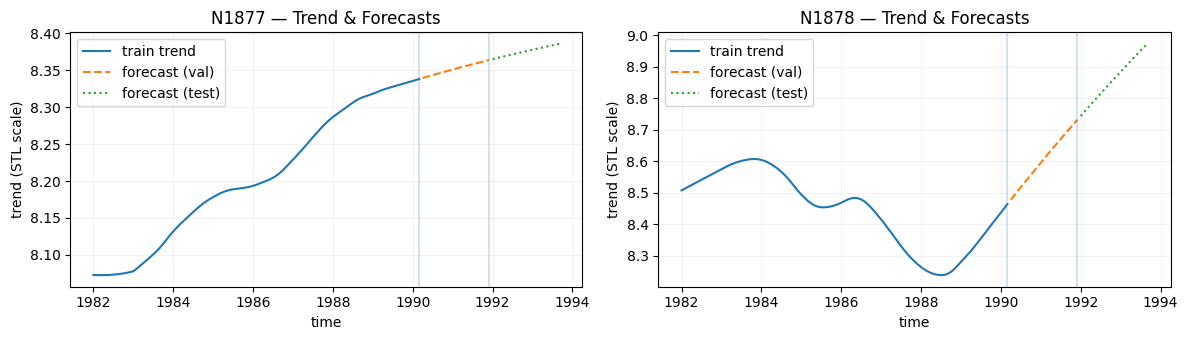

In [804]:
import math
import matplotlib.pyplot as plt
import pandas as pd

def plot_trend_train_val_test_fcst(
    trend_train: pd.DataFrame,          # STL output on TRAIN (has 'trend')
    val_fcst_df: pd.DataFrame,        # from holt_trend_forecast_to_val(...)[0]
    test_fcst_df: pd.DataFrame = None,# from holt_trend_forecast_to_val(...)[1]
    id_col: str = "Series",
    time_col: str = "date",
    trend_col: str = "trend",
    ids: list[str] | None = None,     # subset of IDs to plot
    max_cols: int = 3,
    figsize_per_plot=(6, 3.5)
):
    train = (trend_train[[id_col, time_col, trend_col]]
             .dropna(subset=[trend_col]).copy())
    train[time_col] = pd.to_datetime(train[time_col], errors="coerce")
    train = train.dropna(subset=[time_col]).sort_values([id_col, time_col])

    val_fcst = (val_fcst_df[[id_col, time_col, "trend_fcst"]].copy()
                if val_fcst_df is not None and len(val_fcst_df) else
                pd.DataFrame(columns=[id_col, time_col, "trend_fcst"]))
    if len(val_fcst):
        val_fcst[time_col] = pd.to_datetime(val_fcst[time_col], errors="coerce")
        val_fcst = val_fcst.dropna(subset=[time_col]).sort_values([id_col, time_col])

    test_fcst = (test_fcst_df[[id_col, time_col, "trend_fcst"]].copy()
                 if test_fcst_df is not None and len(test_fcst_df) else
                 pd.DataFrame(columns=[id_col, time_col, "trend_fcst"]))
    if len(test_fcst):
        test_fcst[time_col] = pd.to_datetime(test_fcst[time_col], errors="coerce")
        test_fcst = test_fcst.dropna(subset=[time_col]).sort_values([id_col, time_col])

    # which ids to draw
    ids_in_train = train[id_col].drop_duplicates().tolist()
    ids_in_val   = set(val_fcst[id_col]) if len(val_fcst) else set()
    ids_in_test  = set(test_fcst[id_col]) if len(test_fcst) else set()
    if ids is None:
        # plot those present in train and (val or test)
        ids = [i for i in ids_in_train if (i in ids_in_val or i in ids_in_test)]
    if not ids:
        print("No IDs to plot (check inputs).")
        return

    n = len(ids)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows),
        squeeze=False
    )

    for i, gid in enumerate(ids):
        ax = axes[i // ncols][i % ncols]
        gtr = train[train[id_col] == gid]
        gval = val_fcst[val_fcst[id_col] == gid]
        gtst = test_fcst[test_fcst[id_col] == gid]

        # TRAIN trend
        if len(gtr):
            ax.plot(gtr[time_col], gtr[trend_col], label="train trend")

        # VAL forecast
        if len(gval):
            ax.plot(gval[time_col], gval["trend_fcst"], linestyle="--", label="forecast (val)")

        # TEST forecast
        if len(gtst):
            ax.plot(gtst[time_col], gtst["trend_fcst"], linestyle=":", label="forecast (test)")

        # Split markers (use available boundaries)
        if len(gtr):
            split_train_val = gtr[time_col].max()
            ax.axvline(split_train_val, alpha=0.2)
        if len(gval):
            split_val_test = gval[time_col].max()
            ax.axvline(split_val_test, alpha=0.2)

        ax.set_title(f"{gid} — Trend & Forecasts")
        ax.set_xlabel("time")
        ax.set_ylabel("trend (STL scale)")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.15)

    # hide unused axes
    last_i = i
    for j in range(last_i + 1, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    plt.tight_layout()
    plt.show()


# Plot a subset (or omit `ids` to plot all available)
plot_trend_train_val_test_fcst(
    trend_train=trend_train,
    val_fcst_df=trend_val,
    test_fcst_df=trend_test,
    id_col="Series",
    time_col="date",
    trend_col="trend",
    ids=["N1877","N1878"],
)

We forecast seasonality per ID by mapping each future timestamp to its **phase** (e.g., month 1–12) and pulling the **typical seasonal value** for that (ID, phase) from the **TRAIN STL** template (mean/median by phase).  
No model is fit on VAL/TEST → **no leakage**.  
Output aligns seasonal forecasts to the exact VAL/TEST dates on the same (log) scale as STL.

In [805]:
def _phase_from_date(dts: pd.Series, period: int) -> pd.Series:
    """Returns month-of-year (Jan=1 … Dec=12)"""
    dts = pd.to_datetime(dts)
    return dts.dt.month              
    

def build_seasonal_template_panel(
    season_train: pd.DataFrame,
    id_col: str = "Series",
    time_col: str = "date",
    seasonal_col: str = "seasonal",
    period: int = 12,
    agg: str = "mean",   # or "median"
) -> pd.DataFrame:
    """
    Returns a template: per (ID, phase) -> typical seasonal value.
    Columns: [id_col, 'phase', 'seasonal_tpl'] with phase in 1..period.
    """
    # season_train["Series", "date", "seasonal"]
    df = season_train[[id_col, time_col, seasonal_col]].dropna().copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    # order by time and IDs
    df = df.dropna(subset=[time_col]).sort_values([id_col, time_col])

    df["phase"] = _phase_from_date(df[time_col], period)
    if agg == "median":
        tpl = df.groupby([id_col, "phase"], sort=False)[seasonal_col].median().rename("seasonal_tpl")
    else:
        tpl = df.groupby([id_col, "phase"], sort=False)[seasonal_col].mean().rename("seasonal_tpl")

    tpl = tpl.reset_index()

    return tpl


In [806]:
def seasonal_forecast_val_test(
    season_train: pd.DataFrame,  # STL on TRAIN (has 'seasonal')
    val_df: pd.DataFrame,        # VAL rows with dates per ID
    test_df: pd.DataFrame | None = None,
    id_col: str = "Series",
    time_col: str = "date",
    seasonal_col: str = "seasonal",
    period: int = 12,
    agg: str = "mean",     # "mean" or "median" when building template
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build a seasonal template from TRAIN, then map VAL/TEST dates to phases.
    Returns:
      val_seas  : [id, date, seasonal_fcst]
      test_seas : [id, date, seasonal_fcst] (empty if test_df is None)
    """
    tpl = build_seasonal_template_panel(
        season_train, id_col=id_col, time_col=time_col,
        seasonal_col=seasonal_col, period=period, agg=agg
    )

    global_tpl = (tpl.groupby("phase", sort=False)["seasonal_tpl"]
                    .mean().rename("global_tpl").reset_index())

    def _map_dates(df_future: pd.DataFrame) -> pd.DataFrame:
        if df_future is None or len(df_future) == 0:
            return pd.DataFrame(columns=[id_col, time_col, "seasonal_fcst"])
        fut = df_future[[id_col, time_col]].copy()
        fut[time_col] = pd.to_datetime(fut[time_col], errors="coerce")
        fut = fut.dropna(subset=[time_col]).sort_values([id_col, time_col])
        fut["phase"] = _phase_from_date(fut[time_col], period)

        out = (fut.merge(tpl, on=[id_col, "phase"], how="left")
                  .merge(global_tpl, on="phase", how="left"))
        out["seasonal_fcst"] = out["seasonal_tpl"].where(out["seasonal_tpl"].notna(), out["global_tpl"])
        return out[[id_col, time_col, "seasonal_fcst"]]

    val_seas  = _map_dates(val_df)
    test_seas = _map_dates(test_df) if test_df is not None else pd.DataFrame(columns=[id_col, time_col, "seasonal_fcst"])
    return val_seas, test_seas


In [807]:
import math
import matplotlib.pyplot as plt

def plot_seasonal_train_val_test(
    season_train: pd.DataFrame,   # STL on TRAIN (has 'seasonal')
    val_seas_df: pd.DataFrame,    # from seasonal_forecast_val_test(...)[0]
    test_seas_df: pd.DataFrame = None,  # from seasonal_forecast_val_test(...)[1]
    id_col: str = "Series",
    time_col: str = "date",
    seasonal_col: str = "seasonal",
    ids: list[str] | None = None,
    max_cols: int = 3,
    figsize_per_plot=(6, 3.5),
    title_suffix: str = "Seasonal (train) & Forecasts"
):
    tr = (season_train[[id_col, time_col, seasonal_col]]
          .dropna(subset=[seasonal_col]).copy())
    tr[time_col] = pd.to_datetime(tr[time_col], errors="coerce")
    tr = tr.dropna(subset=[time_col]).sort_values([id_col, time_col])

    val = (val_seas_df[[id_col, time_col, "seasonal_fcst"]].copy()
           if val_seas_df is not None and len(val_seas_df) else
           pd.DataFrame(columns=[id_col, time_col, "seasonal_fcst"]))
    if len(val):
        val[time_col] = pd.to_datetime(val[time_col], errors="coerce")
        val = val.dropna(subset=[time_col]).sort_values([id_col, time_col])

    tst = (test_seas_df[[id_col, time_col, "seasonal_fcst"]].copy()
           if test_seas_df is not None and len(test_seas_df) else
           pd.DataFrame(columns=[id_col, time_col, "seasonal_fcst"]))
    if len(tst):
        tst[time_col] = pd.to_datetime(tst[time_col], errors="coerce")
        tst = tst.dropna(subset=[time_col]).sort_values([id_col, time_col])

    ids_train = tr[id_col].drop_duplicates().tolist()
    ids_val   = set(val[id_col]) if len(val) else set()
    ids_tst   = set(tst[id_col]) if len(tst) else set()
    if ids is None:
        ids = [i for i in ids_train if (i in ids_val or i in ids_tst)]
    if not ids:
        print("No IDs to plot (check inputs).")
        return

    n = len(ids)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows),
        squeeze=False
    )

    for k, gid in enumerate(ids):
        ax = axes[k // ncols][k % ncols]
        gtr  = tr[tr[id_col] == gid]
        gval = val[val[id_col] == gid]
        gtst = tst[tst[id_col] == gid]

        # TRAIN seasonal
        if len(gtr):
            ax.plot(gtr[time_col], gtr[seasonal_col], label="train seasonal")

        # VAL seasonal forecast (template-mapped)
        if len(gval):
            ax.plot(gval[time_col], gval["seasonal_fcst"], linestyle="--", label="forecast (val)")

        # TEST seasonal forecast (template-mapped)
        if len(gtst):
            ax.plot(gtst[time_col], gtst["seasonal_fcst"], linestyle=":", label="forecast (test)")

        # Split markers using available boundaries
        if len(gtr):
            ax.axvline(gtr[time_col].max(), alpha=0.2)
        if len(gval):
            ax.axvline(gval[time_col].max(), alpha=0.2)

        ax.set_title(f"{gid} — {title_suffix}")
        ax.set_xlabel("time")
        ax.set_ylabel("seasonal (same scale as STL)")
        ax.grid(True, alpha=0.15)
        ax.legend(loc="best")

    # hide unused axes
    last_k = k
    for j in range(last_k + 1, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    plt.tight_layout()
    plt.show()


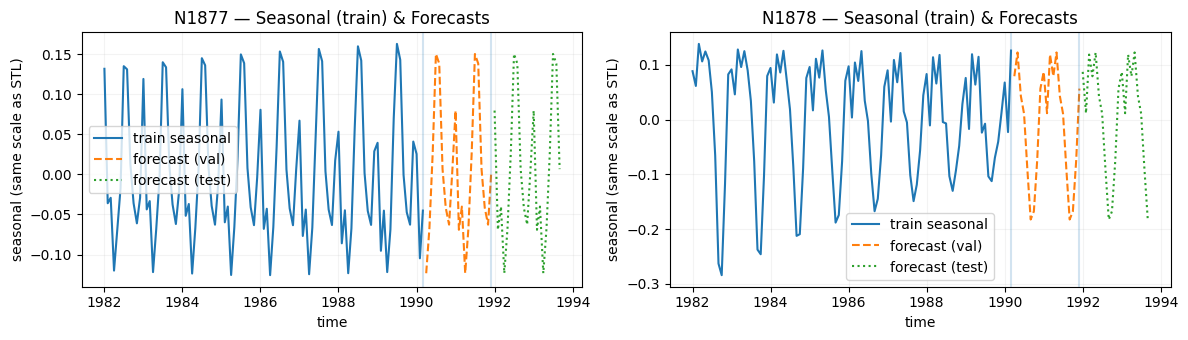

In [808]:
# 1) Build VAL/TEST seasonal forecasts from TRAIN template
season_val, season_test = seasonal_forecast_val_test(
    season_train=season_train,   # STL on TRAIN only
    val_df=val_df,
    test_df=test_df,          
    id_col="Series",
    time_col="date",
    seasonal_col="seasonal",
    period=12,                
    agg="mean",
)

# 2) Plot
plot_seasonal_train_val_test(
    season_train=season_train,
    val_seas_df=season_val,
    test_seas_df=season_test,
    id_col="Series",
    time_col="date",
    seasonal_col="seasonal",
    ids=["N1877","N1878"],    
)


In [809]:
season_val.head()

,Series,date,seasonal_fcst
0,N1877,1990-04-01,-0.123393
1,N1877,1990-05-01,-0.067412
2,N1877,1990-06-01,0.027362
3,N1877,1990-07-01,0.150411
4,N1877,1990-08-01,0.138392


Based on the predicted trends and seasonality of the val and test datasets, we are going to decompose from the actual values, the residuals datapoints

In [810]:
def compute_resid_log_val_test(
    val_df: pd.DataFrame,                 # true VAL: [id_col, time_col, value_col]
    test_df: pd.DataFrame | None,         # true TEST
    trend_val_fcst: pd.DataFrame,         # [id_col, time_col, trend_fcst]
    trend_test_fcst: pd.DataFrame | None, # [id_col, time_col, trend_fcst] 
    seas_val_fcst: pd.DataFrame,          # [id_col, time_col, seasonal_fcst]
    seas_test_fcst: pd.DataFrame | None,  # [id_col, time_col, seasonal_fcst] 
    *,
    id_col: str = "Series",
    time_col: str = "date",
    value_col: str = "value",
    transform: str = "log",               # "none" | "log" | "log1p"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute ONLY model-scale residuals:
        resid_log = y_trans - (trend_fcst + seasonal_fcst)

    Returns (val_resid_log_df, test_resid_log_df) with columns:
      [id_col, time_col, 'y_trans', 'trend_fcst', 'seasonal_fcst', 'yhat_log', 'resid_log']
    """
    def _prep_truth(df):
        # we need to apply transform to val/test dataset because we also applied to the training dataset
        out = df[[id_col, time_col, value_col]].copy()
        out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
        out = out.dropna(subset=[time_col, value_col]).sort_values([id_col, time_col])

        if transform == "none":
            out["value_trans"] = out[value_col].astype(float)
        elif transform == "log":
            if (out[value_col] <= 0).any():
                raise ValueError("Found non-positive values in truth but transform='log'.")
            out["value_trans"] = np.log(out[value_col].astype(float))
        elif transform == "log1p":
            out["value_trans"] = np.log1p(out[value_col].astype(float))
        else:
            raise ValueError("transform must be one of {'none','log','log1p'}.")
        return out[[id_col, time_col, "value_trans"]]

    def _prep_comp(tr_fc, se_fc):
        tr = tr_fc[[id_col, time_col, "trend_fcst"]].copy()
        se = se_fc[[id_col, time_col, "seasonal_fcst"]].copy()
        tr[time_col] = pd.to_datetime(tr[time_col], errors="coerce")
        se[time_col] = pd.to_datetime(se[time_col], errors="coerce")
        m = (tr.dropna(subset=[time_col])
               .merge(se.dropna(subset=[time_col]), on=[id_col, time_col], how="inner")
               .sort_values([id_col, time_col]))
        m["yhat"] = m["trend_fcst"] + m["seasonal_fcst"]
        return m

    def _assemble(truth, comp):
        m = (truth.merge(comp, on=[id_col, time_col], how="inner")
                   .sort_values([id_col, time_col]))
        m["resid"] = m["value_trans"] - m["yhat"]
        return m[[id_col, time_col, "value_trans",
                  "trend_fcst", "seasonal_fcst", "yhat", "resid"]]

    # VAL
    truth_val = _prep_truth(val_df)
    comp_val  = _prep_comp(trend_val_fcst, seas_val_fcst)
    val_resid_log = _assemble(truth_val, comp_val)

    # TEST
    if test_df is None or trend_test_fcst is None or seas_test_fcst is None:
        test_resid_log = pd.DataFrame(columns=val_resid_log.columns)
    else:
        truth_test = _prep_truth(test_df)
        comp_test  = _prep_comp(trend_test_fcst, seas_test_fcst)
        test_resid_log = _assemble(truth_test, comp_test)

    return val_resid_log, test_resid_log

val_resid, test_resid = compute_resid_log_val_test(
    val_df=val_df,
    test_df=test_df,
    trend_val_fcst=trend_val,         # from holt_trend_forecast_to_val(...)
    trend_test_fcst=trend_test,
    seas_val_fcst=season_val,          # from seasonal_forecast_val_test(...)
    seas_test_fcst=season_test,
    id_col="Series",
    time_col="date",
    value_col="value",
    transform="log",                  # match your STL transform
)

val_resid.query("Series == 'N1877'").head()

,Series,date,value_trans,trend_fcst,seasonal_fcst,yhat,resid
0,N1877,1990-04-01,8.219870,8.339616,-0.123393,8.216223,0.003647
1,N1877,1990-05-01,8.273372,8.340923,-0.067412,8.273511,-0.000139
2,N1877,1990-06-01,8.395315,8.342220,0.027362,8.369582,0.025733
3,N1877,1990-07-01,8.487023,8.343507,0.150411,8.493918,-0.006896
4,N1877,1990-08-01,8.506880,8.344784,0.138392,8.483176,0.023704


Here we create resid_val and resid_test where we are going to store the residuals(of each ID) based on the diff from y - forecasted season - forecasted trend

In [811]:
resid_val = val_resid[["Series", "date", "resid"]]
resid_train.head()

,Series,date,resid
0,N1877,1982-01-01,-0.001995
1,N1877,1982-02-01,-0.006373
2,N1877,1982-03-01,0.013777
3,N1877,1982-04-01,0.017648
4,N1877,1982-05-01,-0.002018


In [812]:
resid_test = test_resid[["Series", "date", "resid"]]
resid_train.head()

,Series,date,resid
0,N1877,1982-01-01,-0.001995
1,N1877,1982-02-01,-0.006373
2,N1877,1982-03-01,0.013777
3,N1877,1982-04-01,0.017648
4,N1877,1982-05-01,-0.002018


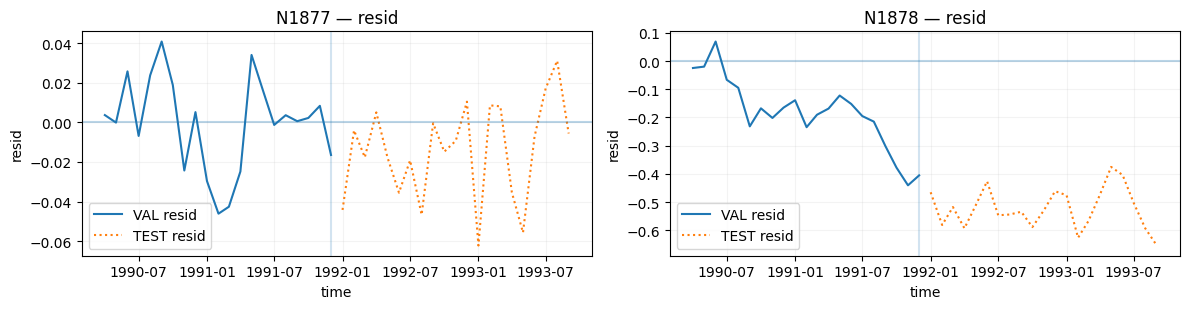

In [813]:


def plot_resid_log_val_test(
    val_resid_df: pd.DataFrame,          # must contain ['Series','date','resid_log']
    test_resid_df: pd.DataFrame = None,  # optional ['Series','date','resid_log']
    id_col: str = "Series",
    time_col: str = "date",
    ids: list[str] | None = None,
    max_cols: int = 3,
    figsize_per_plot=(6, 3.2),
    train_end_by_id: dict | None = None, # optional: {id: last_train_timestamp}
):
    """
    Plot model-scale residuals (resid) for VAL and TEST per ID, with 0 baseline.
    """
    def _prep(df):
        if df is None or len(df) == 0:
            return pd.DataFrame(columns=[id_col, time_col, "resid"])
        cols = [id_col, time_col, "resid"]
        missing = [c for c in cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns in residuals df: {missing}")
        out = df[cols].copy()
        out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
        out = out.dropna(subset=[time_col, "resid"]).sort_values([id_col, time_col])
        return out

    v = _prep(val_resid_df)
    t = _prep(test_resid_df)

    ids_val  = set(v[id_col]) if len(v) else set()
    ids_test = set(t[id_col]) if len(t) else set()

    if ids is None:
        ids = sorted(ids_val.union(ids_test))
    if not ids:
        print("Nothing to plot: no resid rows.")
        return

    n = len(ids)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows),
        squeeze=False
    )

    for i, gid in enumerate(ids):
        ax = axes[i // ncols][i % ncols]
        gv = v[v[id_col] == gid]
        gt = t[t[id_col] == gid] if len(t) else pd.DataFrame(columns=gv.columns)

        # VAL residuals
        if len(gv):
            ax.plot(gv[time_col], gv["resid"], label="VAL resid")

        # TEST residuals
        if len(gt):
            ax.plot(gt[time_col], gt["resid"], linestyle=":", label="TEST resid")

        # Zero baseline
        if len(gv) or len(gt):
            ax.axhline(0.0, alpha=0.3)

        # Optional split markers
        if train_end_by_id and gid in train_end_by_id:
            ax.axvline(pd.to_datetime(train_end_by_id[gid]), alpha=0.2)
        if len(gv):
            ax.axvline(gv[time_col].max(), alpha=0.2)  # end of VAL

        ax.set_title(f"{gid} — resid")
        ax.set_xlabel("time")
        ax.set_ylabel("resid")
        ax.grid(True, alpha=0.15)
        ax.legend(loc="best")

    # hide unused axes
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    plt.tight_layout()
    plt.show()

plot_resid_log_val_test(
    val_resid_df=resid_val,   # from compute_resid_log_val_test(...)
    test_resid_df=resid_test,
    id_col="Series",
    time_col="date",
    ids=["N1877","N1878"],        # or omit to plot all
)



This function takes the log that was created while we were applying diff() to the training residuals to make them stationary(for each Id)

In [814]:
def apply_precomputed_diffs(df, decisions, *, id_col="Series", time_col="date", value_col="resid"):
    out = []
    dec = decisions.set_index(id_col)
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col, value_col]).sort_values([id_col, time_col])
    target_col = "resid"

    for gid, g in df.groupby(id_col, sort=False):
        gg = g.sort_values(time_col).copy()
        x = gg[value_col].astype(float)

        d = int(dec.loc[gid, "d"]) if gid in dec.index and pd.notna(dec.loc[gid, "d"]) else 0

        y = x.copy()
        for _ in range(d):
            y = y.diff()

        gg[target_col] = y.values
        out.append(gg.dropna(subset=[target_col]))

    return pd.concat(out, ignore_index=True) if out else df.assign(**{target_col: pd.NA}).dropna(subset=[target_col])

val_resid  = apply_precomputed_diffs(val_resid,  diff_log, id_col="Series", time_col="date", value_col="resid")
test_resid = apply_precomputed_diffs(test_resid, diff_log, id_col="Series", time_col="date", value_col="resid")
val_resid.head()

,Series,date,value_trans,trend_fcst,seasonal_fcst,yhat,resid
0,N1877,1990-04-01,8.219870,8.339616,-0.123393,8.216223,0.003647
1,N1877,1990-05-01,8.273372,8.340923,-0.067412,8.273511,-0.000139
2,N1877,1990-06-01,8.395315,8.342220,0.027362,8.369582,0.025733
3,N1877,1990-07-01,8.487023,8.343507,0.150411,8.493918,-0.006896
4,N1877,1990-08-01,8.506880,8.344784,0.138392,8.483176,0.023704


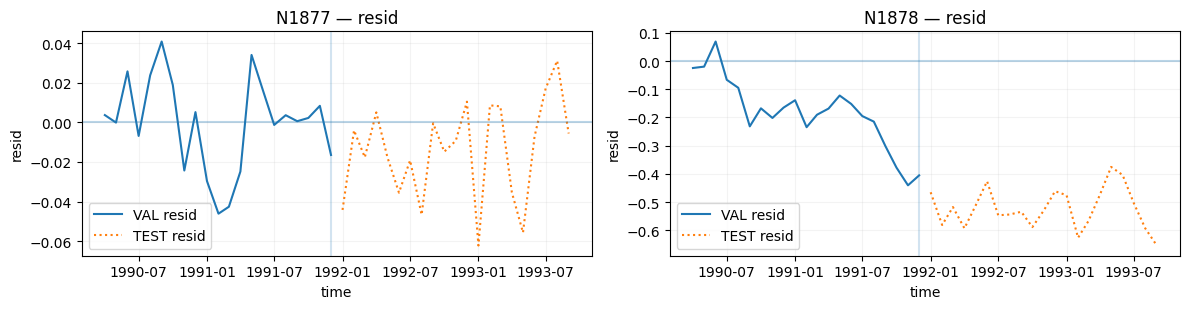

In [ ]:
plot_resid_log_val_test(
    val_resid_df=val_resid,   # from compute_resid_log_val_test(...)
    test_resid_df=test_resid,
    id_col="Series",
    time_col="date",
    ids=["N1877","N1878"],        
)


Here we are normalizing the val/test residuals with the training mean and variance 

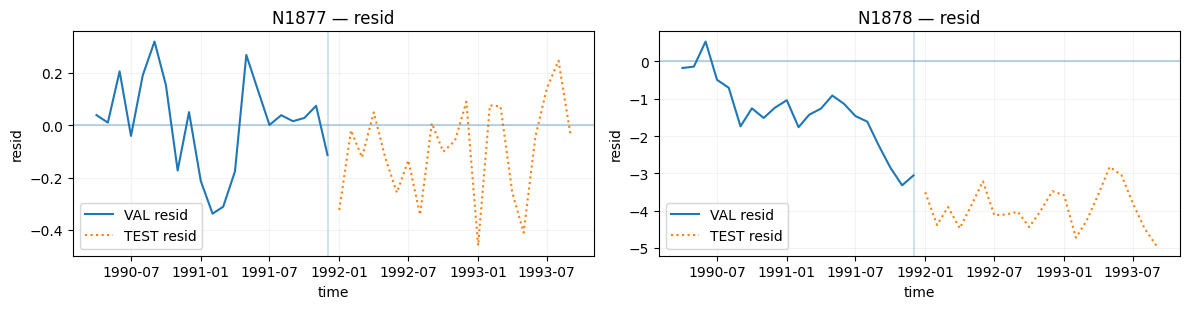

In [817]:
val_norm  = transform_global_zscore(val_resid,  scaler, value_col="resid", out_col="resid")
test_norm = transform_global_zscore(test_resid, scaler, value_col="resid", out_col="resid")
plot_resid_log_val_test(
    val_resid_df=val_norm,   # from compute_resid_log_val_test(...)
    test_resid_df=test_norm,
    id_col="Series",
    time_col="date",
    ids=["N1877","N1878"],       
)

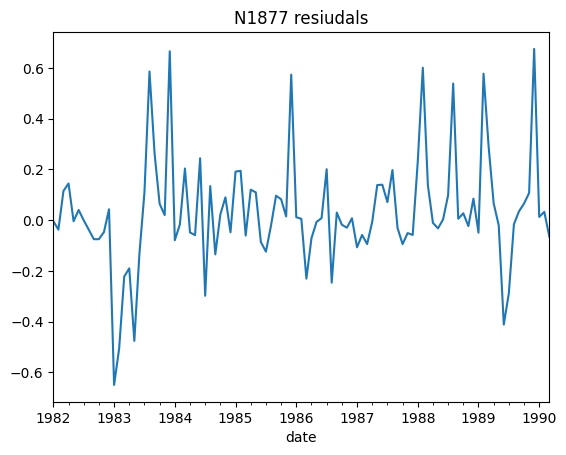

In [819]:
train_scaled.query("Series == 'N1877'").sort_values('date').set_index('date')['resid'].plot(title='N1877 resiudals'); 


In [821]:
import os
from pathlib import Path

main_directory = Path.cwd().resolve().parent
print(main_directory)

out_dir = main_directory / "data/preprocessed"                 
os.makedirs(out_dir, exist_ok=True) 
     
csv_path_1 = os.path.join(out_dir, "trend_train.csv")
trend_train.to_csv(csv_path_1, index=False)

csv_path_2 = os.path.join(out_dir, "trend_val.csv")
trend_val.to_csv(csv_path_2, index=False)

csv_path_3 = os.path.join(out_dir, "trend_test.csv")
trend_test.to_csv(csv_path_3, index=False)

csv_path_4 = os.path.join(out_dir, "season_train.csv")
season_train.to_csv(csv_path_4, index=False)

csv_path_5 = os.path.join(out_dir, "season_val.csv")
season_val.to_csv(csv_path_5, index=False)

csv_path_6 = os.path.join(out_dir, "season_test.csv")
season_test.to_csv(csv_path_6, index=False)

csv_path_7 = os.path.join(out_dir, "resid_train.csv")
resid_train.to_csv(csv_path_7, index=False)

csv_path_8 = os.path.join(out_dir, "resid_val.csv")
resid_val.to_csv(csv_path_8, index=False)

csv_path_9 = os.path.join(out_dir, "resid_test.csv")
resid_test.to_csv(csv_path_9, index=False)



print("Saved:", csv_path_1, csv_path_2, csv_path_3, csv_path_4, csv_path_5, csv_path_6, csv_path_7, csv_path_8, csv_path_9)

/Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting
Saved: /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/trend_train.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/trend_val.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/trend_test.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/season_train.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/season_val.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/season_test.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forecasting/data/preprocessed/resid_train.csv /Users/bogdansandoiu/Documents/Neural Networks/Stocks Forecasting/Stocks-forec